In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

In this notebook, you will implement the kinematic bicycle model. The model accepts velocity and steering rate inputs and steps through the bicycle kinematic equations. Once the model is implemented, you will provide a set of inputs to drive the bicycle in a figure 8 trajectory.

The bicycle kinematics are governed by the following set of equations:

\begin{align*}
\dot{x}_c &= v \cos{(\theta + \beta)} \\
\dot{y}_c &= v \sin{(\theta + \beta)} \\
\dot{\theta} &= \frac{v \cos{\beta} \tan{\delta}}{L} \\
\dot{\delta} &= \omega \\
\beta &= \tan^{-1}(\frac{l_r \tan{\delta}}{L})
\end{align*}

where the inputs are the bicycle speed $v$ and steering angle rate $\omega$. The input can also directly be the steering angle $\delta$ rather than its rate in the simplified case. The Python model will allow us both implementations.

In order to create this model, it's a good idea to make use of Python class objects. This allows us to store the state variables as well as make functions for implementing the bicycle kinematics. 

The bicycle begins with zero initial conditions, has a maximum turning rate of 1.22 rad/s, a wheelbase length of 2m, and a length of 1.2m to its center of mass from the rear axle.

From these conditions, we initialize the Python class as follows:

In [2]:
class Bicycle():
    def __init__(self):
        self.state = {}
        self.state['x'] = 0
        self.state['y'] = 0
        self.state['heading_angle'] = 0
        self.state['steering_angle'] = 0
        
        self.slip_angle = 0
        
        self.length = 2  # Distance between Front Wheel and Rear Wheel
        self.length_rear = 1.2 # Distance between Center of Gravity and Rear Wheel
        self.angular_velocity_max = 1.22 #Physical Limit of the Vehicle
        
        self.time_delta = 10e-3
        
    def reset(self):
        #Resetting everything back to zero
        self.state['x'] = 0
        self.state['y'] = 0
        self.state['heading_angle'] = 0
        self.state['steering_angle'] = 0
        self.slip_angle = 0
    
    def step(self, linear_velocity, angular_velocity):
        # Setting Angular Velocity with in boundary
        if angular_velocity > 0:
            angular_velocity = min(angular_velocity, self.angular_velocity_max)
        else:
            angular_velocity = max(angular_velocity, -self.angular_velocity_max)
            
        self.slip_angle = np.arctan(self.length_rear * np.tan(self.state['steering_angle']) / self.length)
        
        velocity_x = linear_velocity * np.cos(self.state['heading_angle'] + self.slip_angle)
        velocity_y = linear_velocity * np.sin(self.state['heading_angle'] + self.slip_angle)
        
        heading_angle_rate = linear_velocity * np.cos(self.slip_angle) * np.tan(self.state['steering_angle'])/self.length
        steering_angle_rate = angular_velocity
        
        #update state using Euler integration
        self.state['x'] += velocity_x * self.time_delta
        self.state['y'] += velocity_y * self.time_delta
        self.state['heading_angle'] += heading_angle_rate * self.time_delta
        self.state['steering_angle'] += steering_angle_rate * self.time_delta

## Circle
With the model setup, we can now start giving bicycle inputs and producing trajectories. 

Suppose we want the model to travel a circle of radius 10 m in 20 seconds. Using the relationship between the radius of curvature and the steering angle, the desired steering angle can be computed.

\begin{align*}
    \tan{\delta} &= \frac{L}{r} \\
    \delta &= \tan^{-1}(\frac{L}{r}) \\
           &= \tan^{-1}(\frac{2}{10}) \\
           &= 0.1974
\end{align*}

If the steering angle is directly set to 0.1974 using a simplied bicycled model, then the bicycle will travel in a circle without requiring any additional steering input. 

The desired speed can be computed from the circumference of the circle:

\begin{align*}
    v &= \frac{d}{t}\\
     &= \frac{2 \pi 10}{20}\\
     &= \pi
\end{align*}

We can now implement this in a loop to step through the model equations. We will also run our bicycle model solution along with your model to show you the expected trajectory. This will help you verify the correctness of your model.

#### With Slip Angle

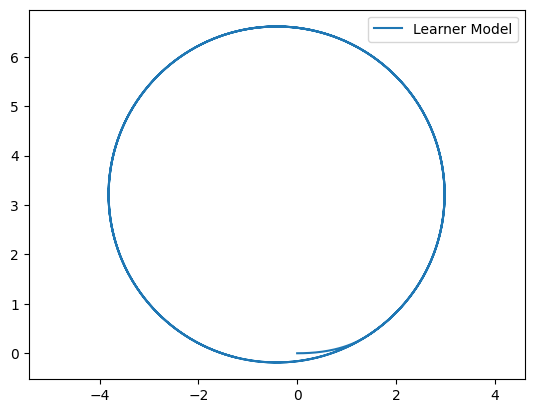

In [3]:
radius = 10
time_limit = 20
model = Bicycle()
model.reset()

t_data = np.arange(0,time_limit,model.time_delta)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)

for i in range(t_data.shape[0]):
    x_data[i] = model.state['x']
    y_data[i] = model.state['y']
    
    if model.state['heading_angle'] < np.arctan(model.length /radius):
        model.step(np.pi, model.angular_velocity_max)
    else:
        model.step(np.pi, 0)

plt.axis('equal')
plt.plot(x_data, y_data,label='Learner Model')
plt.legend()
plt.show()

#### Without Slip Angle

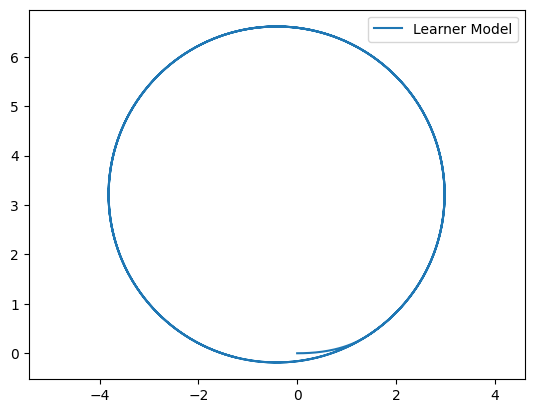

In [4]:
model.reset()

x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)

for i in range(t_data.shape[0]):
    x_data[i] = model.state['x']
    y_data[i] = model.state['y']
    
    if model.state['heading_angle'] < np.arctan(model.length /radius):
        model.step(np.pi, model.angular_velocity_max)
    else:
        model.step(np.pi, 0)
    
    model.slip_angle = 0

plt.axis('equal')
plt.plot(x_data, y_data,label='Learner Model')
plt.legend()
plt.show()

## Square

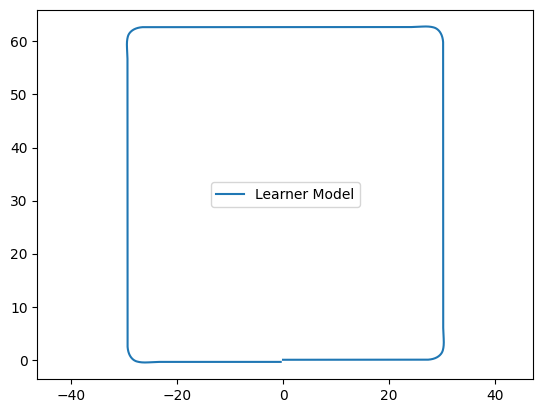

In [5]:
model.reset()
time_limit = 60
t_data = np.arange(0,time_limit,model.time_delta)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)


# maintain velocity at 4 m/s
v_data = np.zeros_like(t_data)
v_data[:] = 4

w_data = np.zeros_like(t_data)

# ==================================
#  Square Path: set w at corners only
# ==================================
w_data[670:670+100] = 0.753
w_data[670+100:670+100*2] = -0.753
w_data[2210:2210+100] = 0.753
w_data[2210+100:2210+100*2] = -0.753
w_data[3670:3670+100] = 0.753
w_data[3670+100:3670+100*2] = -0.753
w_data[5220:5220+100] = 0.753
w_data[5220+100:5220+100*2] = -0.753

for i in range(t_data.shape[0]):
    x_data[i] = model.state['x']
    y_data[i] = model.state['y']
    
    model.step(v_data[i], w_data[i])
    
plt.axis('equal')
plt.plot(x_data, y_data,label='Learner Model')
plt.legend()
plt.show()

#### Without Slip

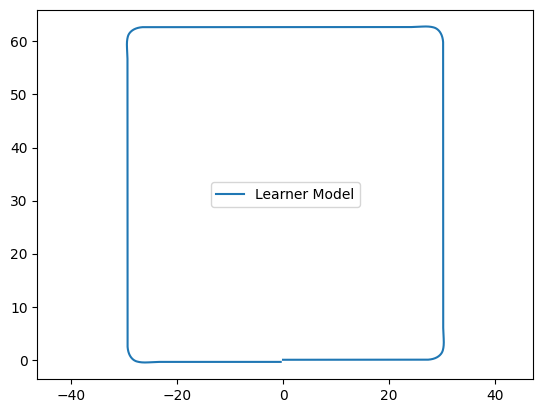

In [6]:
model.reset()

x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)

for i in range(t_data.shape[0]):
    x_data[i] = model.state['x']
    y_data[i] = model.state['y']
    
    model.step(v_data[i], w_data[i])
    model.slip_angle = 0
    
plt.axis('equal')
plt.plot(x_data, y_data,label='Learner Model')
plt.legend()
plt.show()

## Spiral

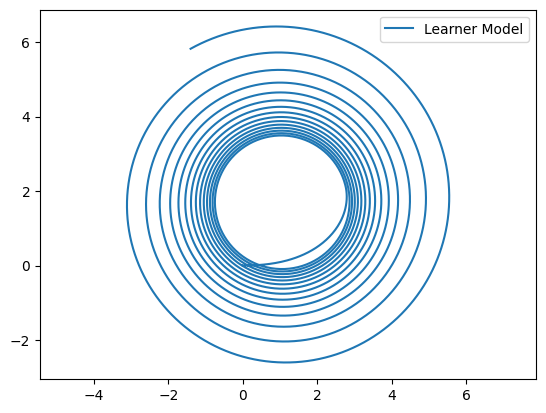

In [7]:
model.reset()

x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)


w_data = np.zeros_like(t_data)

# ==================================
#  Spiral Path: high positive w, then small negative w
# ==================================
w_data[:] = -1/100
w_data[0:100] = 1

for i in range(t_data.shape[0]):
    x_data[i] = model.state['x']
    y_data[i] = model.state['y']
    
    model.step(v_data[i], w_data[i])
    
plt.axis('equal')
plt.plot(x_data, y_data,label='Learner Model')
plt.legend()
plt.show()

## Figure 8

![title](artifacts/figure8.png)


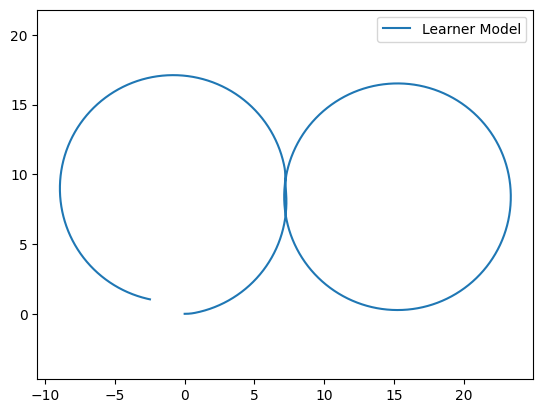

In [8]:
model.reset()
time_limit = 30

t_data = np.arange(0,time_limit,model.time_delta)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
v_data = np.zeros_like(t_data)
w_data = np.zeros_like(t_data)

radius = 8
delta = 0.993 * np.arctan(model.length / radius)  #multiplied by 0.993 only for better accuracy
v_data[:] = (2 * np.pi * 2 * radius) / (time_limit)


for i in range(t_data.shape[0]):
    x_data[i] = model.state['x']
    y_data[i] = model.state['y']
    
    #Since the velocity is constant we can divide the path into 8 slices
    #w changes at t_data.shape[0]/8, (5*t_data.shape[0])/8.
    if i <= t_data.shape[0]/8:
        if model.state['steering_angle'] < delta:
            model.step(v_data[i], model.angular_velocity_max)
            w_data[i] = model.angular_velocity_max
        else:
            model.step(v_data[i], 0)
            w_data[i] = 0
    elif i <= (5.1*t_data.shape[0])/8:
        if model.state['steering_angle'] > -delta:
            model.step(v_data[i], -model.angular_velocity_max)
            w_data[i] = -model.angular_velocity_max
        else:
            model.step(v_data[i], 0)
            w_data[i] = 0
    else:
        if model.state['steering_angle'] < delta:
            model.step(v_data[i], model.angular_velocity_max)
            w_data[i] = model.angular_velocity_max
        else:
            model.step(v_data[i], 0)
            w_data[i] = 0
            
plt.axis('equal')
plt.plot(x_data, y_data,label='Learner Model')
plt.legend()
plt.show()